# Decision Trees And MADM Notebook
## Main questions of interest:
<ol> 
<li>Which descriptors best predict potency?  How do we validate these?
    <ul>
    <li><strong>F-statistic</strong>; H0: There does not exist a relationship between regression parameters. Ha: There does exist a relationship between regression parameters.</li>
    <li><strong>Mixed Selection (pvalues)</strong>; Best indendent dimensions p-values in OLS.</li>
    <li><strong>Forward Selection R^2</strong>; Best mix of columns to maximize R^2.</li>
    <li><strong>Lasso</strong>; Gridsearch lambda let lasso drop dimensions, plot results.</li>
    <li><strong>PCA</strong>; Consider a PCA on all dimensions EXCLUDED from the methods above, this way we can still capture the most gain from the other dimensions if we want too instead of just dropping them.</li>
    <li>[...]</li>
    <li>[...]</li>
    </ul> 
</li>

<li>Can we augment the data set with predicted negative data (molecules expected to be inactive) to improve our machine learning models? Are there certain characteristics of negative data sets that are the most useful for training?
    <ul>
        <li>What value should IC50 be filled with (zero?)</li>
        <li>What attributes relate most to the negative data?</li>
        <li>Explore similar techniques from (1)</li>
        <li><strong>K=2</strong>; Now we know for sure there is a binary partition in the data, because we manufactured it.</li>
        <li><strong>SVM</strong>; We also know that a p-space hyperplace should classify this into two groups, making SVM a valuable option as well.</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>

<li>Given the limited size of the data set and the high cost of experiments, can we use ML to identify the missing data that would be best for model training?
    <ul>
        <li><strong>KNR</strong>; What are my 5 nearest neighbors, make me interpolate me like them.</li>
        <li><strong>Bayes</strong> (Posterior Probabiliy); bin the response, Find max likelihood of me being in that bin, if I am in that bin, grab everyone else in that bin and draw a probability of me like that bins mean/std.</li>
        <li><strong>Naive Bayes</strong> (Posterior Probabiliy); same logic as bayes except independence assumption.</li>
        <li><strong>Markov Chains</strong>; DTMC or CTMC; Based on these probabilities, Assess what the steady state distribution will look like of me <em>bin</em> changing based on the training data's behavior.</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>
<li>Which cluster most closely with OSM-S-106?
    <ul>
        <em>k=2; negative data set and positive dataset.</em>
        <li><strong>Heirarchical Clustering</strong>; How does our heirarchy build and classify?</li>
        <li><strong>EM Clustering</strong>; Take variance into account</li>
        <li><strong>K-means</strong>; Baseline</li>
        <li><strong>KNN</strong>; Do we have nearest neigbors from the negative data?</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>
<li>Would this provide clues as to the mechanism of OSM-S-106?
    <ul>
        <li>Mixed Selection (pvalues)</li>
        <li>Forward Selection R^2</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>
<li>How well do more advanced ML models perform over simple methods like multiple linear regression, SVM, and random forest?
    <ul>
        <li><strong>Random Forest</strong>; Gridsearch number of trees, How do these forests segment our data.</li>
        <li><strong>Adaboost</strong>; Gridsearch alpha (learning rate). Let this guy perfectly fit the data and see how it segments trees for exploratory reasons.</li>
        <li> <strong>Neural Network</strong>; Gridsearch layers. Traditionally they don't do good on this type of problem, but the black box never ceases to amaze in p-space.</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul></li>
</ol>

## Import Libraries
<hr>

In [1]:
# Core
import numpy as np
import pandas as pd
import os
import subprocess
def install_package(name):
    sudoPassword = 'Jesusislife1!'
    command = 'pip install ' + name
    p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))

# Stats
from statsmodels.regression import linear_model
import statsmodels.api as sm

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate


# OR
from skcriteria import Data, MIN, MAX
from skcriteria.madm import closeness, simple

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *

/Library/Python/2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Read in main data
main_df = pd.read_csv("Series3_6.15.17_padel.csv")

# Read in placebos data
placebo_1 = pd.read_csv("Akt1_decoys_padel.csv")
placebo_2 = pd.read_csv("AmpC_decoys_padel.csv")
placebo_3 = pd.read_csv("cp3a4_decoys_padel.csv")
placebo_4 = pd.read_csv("cxcr4_decoys_padel.csv")
placebo_5 = pd.read_csv("HIVpr_decoys_padel.csv")
placebo_6 = pd.read_csv("HIVrt_decoys_padel.csv")
placebo_7 = pd.read_csv("Kif11_decoys_padel.csv")
placebo_8 = pd.read_csv("Selleck_filtered_padel_corrected.csv")

# Append dumby response column.
placebo_1.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_1.shape[0])], dtype="float64"))) 
placebo_2.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_2.shape[0])], dtype="float64"))) 
placebo_3.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_3.shape[0])], dtype="float64"))) 
placebo_4.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_4.shape[0])], dtype="float64"))) 
placebo_5.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_5.shape[0])], dtype="float64"))) 
placebo_6.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_6.shape[0])], dtype="float64"))) 
placebo_7.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_7.shape[0])], dtype="float64"))) 
placebo_8.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_8.shape[0])], dtype="float64"))) 

# Gather our dataframes for collective manipulation
frames = [main_df,   placebo_1, placebo_2, 
          placebo_3, placebo_4, placebo_5,
          placebo_6, placebo_7, placebo_8]

frames[0].head()

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (69,123,664,1142,1143,1146,1147,1184,1185,1186,1225,1226,1227,1228,1229,1230,1249,1412) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Name,IC50,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,OSM-S-106,0.036,0,-1.0958,1.200778,23.1572,39.591930,15,17,30,...,10.200817,40.713610,2.035681,22.242022,4.765434,11.047825,799,31,0.727,110
1,OSM-S-107,10.000,0,1.1547,1.333332,38.0230,49.112481,15,16,40,...,8.202895,48.001779,2.087034,18.848454,0.000000,13.231952,1321,34,3.185,124
2,OSM-S-118,50.000,0,0.5906,0.348808,7.7935,31.554344,15,17,23,...,9.219166,31.354825,2.090322,9.306953,0.000000,6.214417,343,21,4.191,80
3,OSM-S-119,50.000,0,2.2246,4.948845,25.3114,36.320758,15,17,23,...,15.993993,35.091951,2.064232,14.383663,0.000000,6.220694,480,27,5.059,92
4,OSM-S-120,50.000,0,1.3358,1.784362,16.7123,33.937551,15,17,23,...,12.606580,33.230029,2.076877,11.846725,0.000000,6.220707,411,23,4.625,86


In [4]:
# It only makes sense to keep non-null responses.
row_mask=frames[0].isnull().any(axis=1) == False
frames[0] = frames[0].loc[row_mask,:]

# Confirm
frames[0].shape # Correct, it dropped from 70 to 46.

(46, 1446)

### Explore tree based models

1. Grid search random forest regressors; find feature importance.
2. Grid search adaboost trees regressors; find feature importance.



In [5]:
# Optimality Proportion as a percentage. Binned by orders of magnitude in strength.
def categorize(x):
    v=(0.036/x[1])*100
    ret=""
    if v > 10.0:
        ret="High"
    elif v > 1.0:
        ret="MediumHigh"
    elif v > 0.1:
        ret="MediumLow"
    elif v > 0.01:
        ret="Low"
    else:
        ret="Other"
    return ret


### Random Forest Regressor

In [6]:
X                = frames[0].iloc[:,2:].as_matrix()
y                = frames[0].iloc[:,1].as_matrix()

rf_pipe          = Pipeline([('scaler', StandardScaler()),('rf',RandomForestRegressor())])
rf_param_grid    = {'rf__n_estimators':[10,100,1000],
                   'rf__bootstrap':[True, False]}

rf_grid             = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=3, scoring="r2")

rf_fit=rf_grid.fit(X,y)
rf_feat_imp_r = rf_fit.best_estimator_.named_steps["rf"].feature_importances_
rf_feat_imp_r

array([  0.00000000e+00,   5.49721578e-04,   1.81985610e-04, ...,
         3.05072447e-04,   1.52597449e-04,   7.79133593e-05])

### Adaptive Boosting Regressor

In [162]:
X                = frames[0].iloc[:,2:].as_matrix()
y                = frames[0].iloc[:,1].as_matrix()

boost_pipe       = Pipeline([('scaler', StandardScaler()),('boost',AdaBoostRegressor())])

boost_param_grid = {'boost__n_estimators':[50, 500],
                    'boost__learning_rate':[1.0, 0.5, 0.01],
                    'boost__loss':['linear','exponential']}
boost_grid             = GridSearchCV(boost_pipe, param_grid=boost_param_grid, cv=3, scoring="r2")

boost_fit = boost_grid.fit(X,y)
boost_feat_imp_r = boost_fit.best_estimator_.named_steps["boost"].feature_importances_
boost_feat_imp_r

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

### Random Forest Classifier

Present our most important features from our best model.

In [6]:
X                = frames[0].iloc[:,2:].as_matrix()
y                = frames[0].apply(categorize, axis=1).astype('category')

rf_pipe          = Pipeline([('scaler', StandardScaler()),('rf',RandomForestClassifier())])
rf_param_grid    = {'rf__n_estimators':[10,100,1000],
                   'rf__bootstrap':[True, False],
                   'rf__criterion':['gini','entropy']}

rf_grid             = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=3)

rf_fit=rf_grid.fit(X,y)
rf_feat_imp_c = rf_fit.best_estimator_.named_steps["rf"].feature_importances_
rf_feat_imp_c

/Library/Python/2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

### Adaptive Boosting Classifier

Present our most important features from our best model.

In [165]:
X                = frames[0].iloc[:,2:].as_matrix()
y                = frames[0].apply(categorize, axis=1).astype('category')

# Scale and boost
boost_pipe       = Pipeline([('scaler', StandardScaler()),('boost',AdaBoostClassifier())])

boost_param_grid = {'boost__n_estimators':[50, 500],
                    'boost__learning_rate':[5.0, 1.0, 0.5, 0.01],
                    'boost__algorithm':['SAMME','SAMME.R']}
boost_grid             = GridSearchCV(boost_pipe, param_grid=boost_param_grid, cv=3)
boost_fit = boost_grid.fit(X,y)
boost_feat_imp_c = boost_fit.best_estimator_.named_steps["boost"].feature_importances_
boost_feat_imp_c

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

### Explore how well we fit our data

Random forest: 100%

Adaptive Boosting: 73.9%

In [166]:
# Random Forest Classifier
ypred=rf_fit.best_estimator_.predict(X)
ypred
pd.DataFrame(confusion_matrix(y, ypred),
             columns=['High', 'MediumHigh', 'MediumLow', 'Low'],
            index=['High', 'MediumHigh', 'MediumLow', 'Low'])


,High,MediumHigh,MediumLow,Low
High,1,0,0,0
MediumHigh,0,29,0,0
MediumLow,0,0,2,0
Low,0,0,0,14


In [167]:
# Adaptive Boosting Classifier
ypred=boost_fit.best_estimator_.predict(X)
ypred
pd.DataFrame(confusion_matrix(y, ypred),
             columns=['High', 'MediumHigh', 'MediumLow', 'Low'],
             index=['High', 'MediumHigh', 'MediumLow', 'Low'])

,High,MediumHigh,MediumLow,Low
High,1,0,0,0
MediumHigh,0,25,0,4
MediumLow,0,0,2,0
Low,0,8,0,6


### Lasso coefficients


In [193]:
from sklearn.linear_model import Lasso

X                = frames[0].iloc[:,2:].as_matrix()
y                = frames[0].iloc[:,1].as_matrix()

lasso_pipe       = Pipeline([('lasso',Lasso())])

lasso_param_grid = {'lasso__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid             = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid, cv=10)
lasso_fit = lasso_grid.fit(X,y).best_estimator_.named_steps["lasso"]
lasso_fit.coef_[:100]

array([ 0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -2.99127954,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

### OLS p-values

In [168]:
# Standard center/scaling
frames[0].iloc[:,2:] = StandardScaler().fit_transform(frames[0].iloc[:,2:])

In [ ]:
# Generate p-values from independent linear regression
pvalues=list()
for variable in frames[0].iloc[:,2:].columns:
    
    #print("Regressed on: ", variable)
    model = sm.OLS(y, sm.add_constant(frames[0][variable])).fit()
    
    # use all coefs except intercept
    pvalues.append((variable, model.pvalues.iloc[1]))
zip(*pvalues)[1]

pvals=pd.DataFrame({'pvals':zip(*pvalues)[1]}).transform(lambda x:x < 0.05).transform(lambda x: x.replace(False,0))
pvals=map(lambda x: x[0], pvals.as_matrix().tolist())
sum(pvals)

### Transform pvalues to see which were statistically significant.


139.0

### Construct a decision matrix

In [293]:
print len(rf_feat_imp_r)
print len(boost_feat_imp_r)
print len(rf_feat_imp_c)
print len(boost_feat_imp_c)
print len(lasso_fit.coef_)

feat_df = pd.DataFrame({'RF_Regressor':rf_feat_imp_r,
                        'AB_Regressor':boost_feat_imp_r,
                        'RF_Classifier':rf_feat_imp_c,
                        'AB_Classifier':boost_feat_imp_c,
                        'LASSO_Coef':lasso_fit.coef_,
                        #'pvalues':zip(*pvalues)[1],
                        'stat_sig':pvals},
                      index=frames[0].iloc[:,2:].columns)
#feat_df.RF_Regressor = feat_df.RF_Regressor.transform(lambda row: row*10000000)

feat_df=feat_df.fillna(0)
feat_df.LASSO_Coef=feat_df.LASSO_Coef.apply(lambda x:abs(x))

feat_df

1444
1444
1444
1444
1444


,AB_Classifier,AB_Regressor,LASSO_Coef,RF_Classifier,RF_Regressor,stat_sig
nAcid,0.000,0.000000,0.00000,0.000000,0.000000e+00,0.0
ALogP,0.000,0.000000,0.00000,0.000000,6.287653e-04,1.0
ALogp2,0.000,0.000000,0.00000,0.019966,4.870973e-05,0.0
AMR,0.000,0.000000,0.00000,0.000000,6.126402e-05,0.0
apol,0.000,0.000000,0.00000,0.000000,1.395624e-05,0.0
naAromAtom,0.000,0.000000,0.00000,0.000000,5.653142e-06,0.0
nAromBond,0.000,0.000000,0.00000,0.000000,8.688445e-06,0.0
nAtom,0.000,0.000000,0.00000,0.000000,2.471345e-04,0.0
nHeavyAtom,0.000,0.000000,0.00000,0.000000,2.185782e-05,0.0
nH,0.000,0.000000,0.00000,0.000000,4.675677e-05,0.0


### MADM Techniques

Lets explore what the following decision theory algorithms would rank these in:

1. Weighted Sum
2. Weighted Product
3. TOPSIS (Vector Normalized)
4. TOPSIS (Sum Normalized)




In [313]:
mtx = feat_df.as_matrix()
mtx

# let's says the first two alternatives are
# for maximization and the last one for minimization
criteria = [MAX, MAX, MAX, MAX, MAX, MAX]
criteria

data = Data(mtx, criteria,
            weights=[0.16666666666666666,
                     0.16666666666666666,
                     0.16666666666666666,
                     0.16666666666666666,
                     0.16666666666666666,
                     0.16666666666666666,],
            anames=feat_df.index.tolist(),
            cnames=feat_df.columns)

# first create the decision maker
# (with the default hiper parameters)
dm1 = simple.WeightedSum()
dm2 = simple.WeightedProduct()
dm3 = closeness.TOPSIS(mnorm="vector")
dm4 = closeness.TOPSIS(mnorm="sum")

ranks=[]
for alg in [dm1, dm2, dm3, dm4]:
    dec = alg.decide(data)
    ranks.append(dec.rank_) 
# Now lets decide the ranking

rank_matrix= pd.DataFrame(ranks, index=['WeightedSum',
                                     'WeightedProduct',
                                     'TOPSIS_VectorNormalized',
                                     'TOPSIS_SumNormalized'],
                                   columns=feat_df.index).T

rank_matrix.loc[(rank_matrix < 50).any(axis=1)]

,WeightedSum,WeightedProduct,TOPSIS_VectorNormalized,TOPSIS_SumNormalized
nCl,25,7,29,22
nX,32,31,51,28
ATS4i,54,176,40,46
AATS1m,52,174,33,44
AATS7s,51,175,93,43
ATSC3c,41,18,54,66
ATSC4c,55,39,62,71
ATSC7c,33,16,52,33
ATSC5m,5,158,5,5
ATSC8v,31,10,41,29


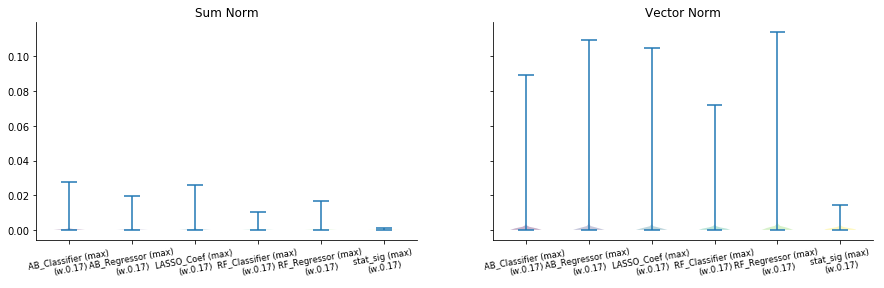

In [302]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title("Sum Norm")
data.plot.violin(mnorm="sum", ax=ax1);

ax2.set_title("Vector Norm")
data.plot.violin(mnorm="vector", ax=ax2);
f.set_figwidth(15)
plt.show()


### Analysis

Based on a few different classifiers, we have tried our best to identify which attributes were the most important in our dataset. These procedures give us a 1..N ranking our how well our attribuets stand up to our feature selection techniques. 